In [22]:
import cellbox
import os
import numpy as np
import pandas as pd
import tensorflow.compat.v1 as tf
import shutil
import argparse
import json
import glob
import time
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

tf.disable_v2_behavior()

In [89]:
# Manually determine the params and all other necessary params
class KernelConfig(object):
    def __init__(self):
        
        self.n_x = 99
        self.envelope_form = "linear" # options: tanh, polynormial, hill, linear, clip linear
        self.envelope_fn = None
        self.polynomial_k = 2 # larger than 1
        self.ode_degree = 1
        self.envelope = 0
        self.ode_solver = "heun" # options: euler, heun, rk4, midpoint
        self.dT = 0.1
        self.n_T = 400
        self.gradient_zero_from = None

args = KernelConfig()
dT = 0.1
n_T = 400
gradient_zero_from = None

#if self.args.envelope == 2:
#    psi = tf.Variable(np.ones((n_x, 1)), name="psi", dtype=tf.float32)
#    self.params['psi'] = tf.nn.softplus(psi)

In [ ]:
W = np.random.randn(args.n_x, args.n_x)
eps = np.ones((args.n_x, 1), dtype=np.float32)
alpha = np.ones((args.n_x, 1), dtype=np.float32)
y0_np = np.zeros((args.n_x, 1))
mu_t_np = np.random.randn(args.n_x, 4)

### Tensorflow code

In [90]:
# import the relevant objects
def tensorflow_results():
    from cellbox.kernel import get_ode_solver, get_envelope, get_dxdt

    params = {}
    W_copy = np.copy(W)
    params["W"] = tf.convert_to_tensor(W_copy, dtype=tf.float32)
    params["alpha"] = tf.convert_to_tensor(np.log(np.exp(alpha) + 1), dtype=tf.float32)
    params["eps"] = tf.convert_to_tensor(np.log(np.exp(eps) + 1), dtype=tf.float32)
    envelope_fn = get_envelope(args)
    ode_solver = get_ode_solver(args)
    _dxdt = get_dxdt(args, params)

    # Determine the input and output shape of the ODE
    mu_t_copy = np.copy(mu_t_np)
    y0 = tf.convert_to_tensor(y0_np, dtype=tf.float32)
    mu_t = tf.convert_to_tensor(mu_t_copy, dtype=tf.float32)
    ys = ode_solver(y0, mu_t, args.dT, args.n_T, _dxdt, gradient_zero_from)
    return ys.eval(session=tf.compat.v1.Session())

In [91]:
ys_tf = tensorflow_results()

### Check Pytorch code

In [92]:
# import the relevant objects
def pytorch_results():
    from cellbox.kernel_torch import get_ode_solver, get_envelope, get_dxdt

    params = {}
    W_copy = np.copy(W)
    params["W"] = torch.tensor(W_copy, dtype=torch.float32)
    params["alpha"] = torch.tensor(np.log(np.exp(alpha) + 1), dtype=torch.float32)
    params["eps"] = torch.tensor(np.log(np.exp(eps) + 1), dtype=torch.float32)
    envelope_fn = get_envelope(args)
    ode_solver = get_ode_solver(args)
    _dxdt = get_dxdt(args, params)

    # Determine the input and output shape of the ODE
    mu_t_copy = np.copy(mu_t_np)
    y0 = torch.tensor(y0_np, dtype=torch.float32)
    mu_t = torch.tensor(mu_t_copy, dtype=torch.float32)
    ys_torch = ode_solver(y0, mu_t, args.dT, args.n_T, _dxdt, gradient_zero_from)

    return ys_torch.numpy()

In [93]:
ys_torch = pytorch_results()

### Analyse results

The plot that shows the maximum and average difference between two functions

In [94]:
#n_T_list = list(range(5, 405, 5))
#diff_max_list = []
#diff_mean_list = []
#for n_T in n_T_list:
#    args.n_T = n_T
#    print(f"Working on time step: {n_T}")
#    tf_out = tensorflow_results()
#    torch_out = pytorch_results()
#    diff_max_list.append(np.amax(np.abs(tf_out - torch_out)))
#    diff_mean_list.append(np.mean(np.abs(tf_out - torch_out)))

assert ys_tf.shape == ys_torch.shape, "The shape of two tensors is not equal"
diff_max_list = []
diff_mean_list = []
for t in range(ys_torch.shape[0]):
    tf_slice = ys_tf[t, ...]
    torch_slice = ys_torch[t, ...]
    diff_max_list.append(np.amax(np.abs(torch_slice - tf_slice)))
    diff_mean_list.append(np.mean(np.abs(torch_slice - tf_slice)))

/tmp/ipykernel_73008/1225683086.py:18: RuntimeWarning: invalid value encountered in subtract
  diff_max_list.append(np.amax(np.abs(torch_slice - tf_slice)))
/tmp/ipykernel_73008/1225683086.py:19: RuntimeWarning: invalid value encountered in subtract
  diff_mean_list.append(np.mean(np.abs(torch_slice - tf_slice)))


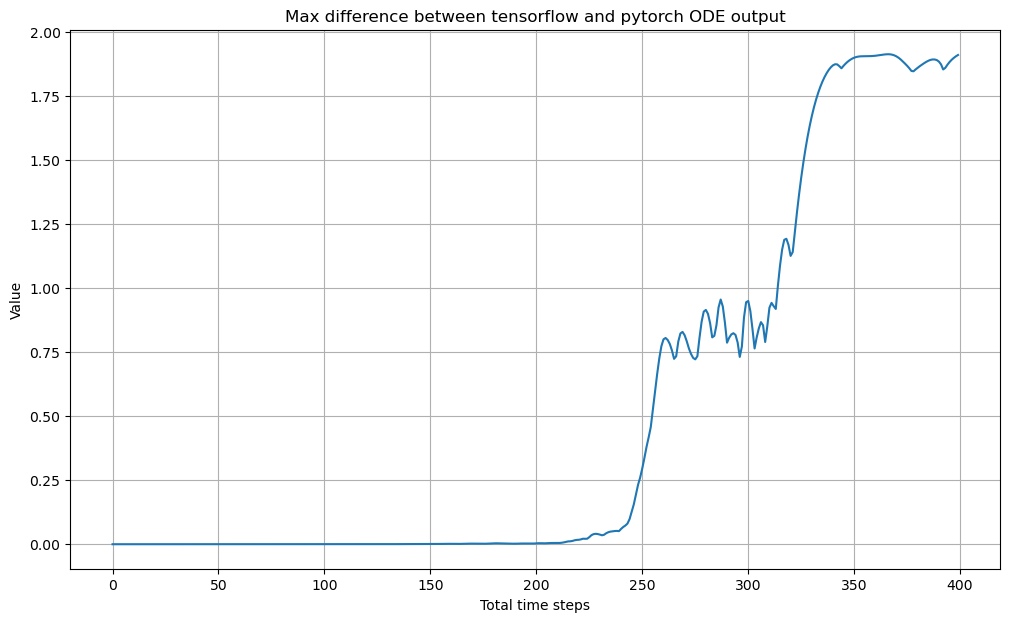

In [87]:
plt.figure(figsize=(12, 7))
plt.plot(diff_max_list)
#plt.xticks(np.arange(len(n_T_list)), n_T_list, rotation=90)
plt.title("Max difference between tensorflow and pytorch ODE output")
plt.xlabel("Total time steps")
plt.ylabel("Value")
plt.grid()
plt.show()

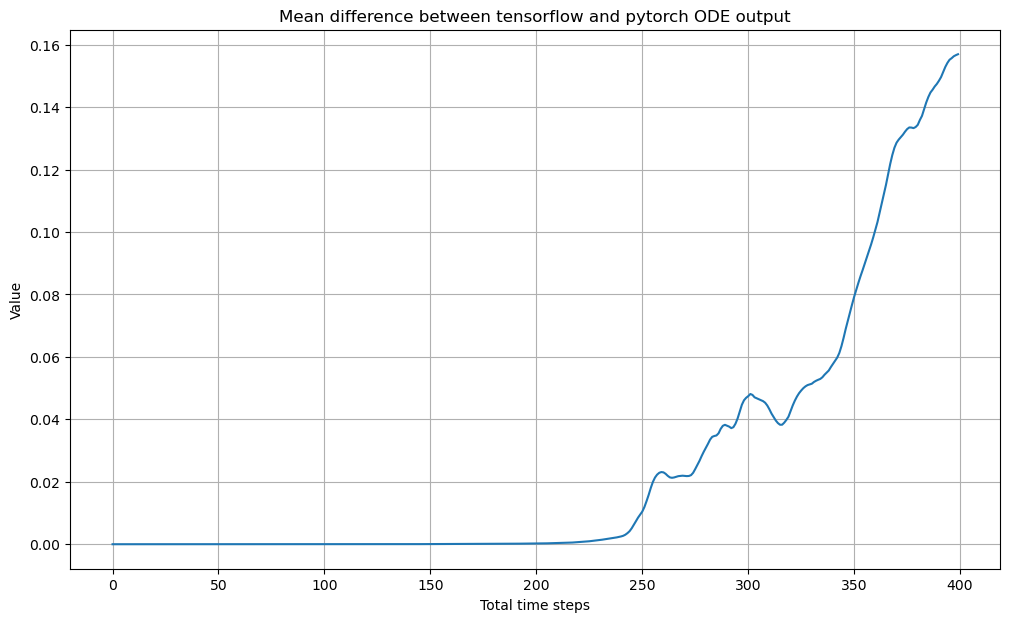

In [67]:
plt.figure(figsize=(12, 7))
plt.plot(diff_mean_list)
#plt.xticks(np.arange(len(n_T_list)), n_T_list, rotation=90)
plt.title("Mean difference between tensorflow and pytorch ODE output")
plt.xlabel("Total time steps")
plt.ylabel("Value")
plt.grid()
plt.show()

Show the actual output of two functions

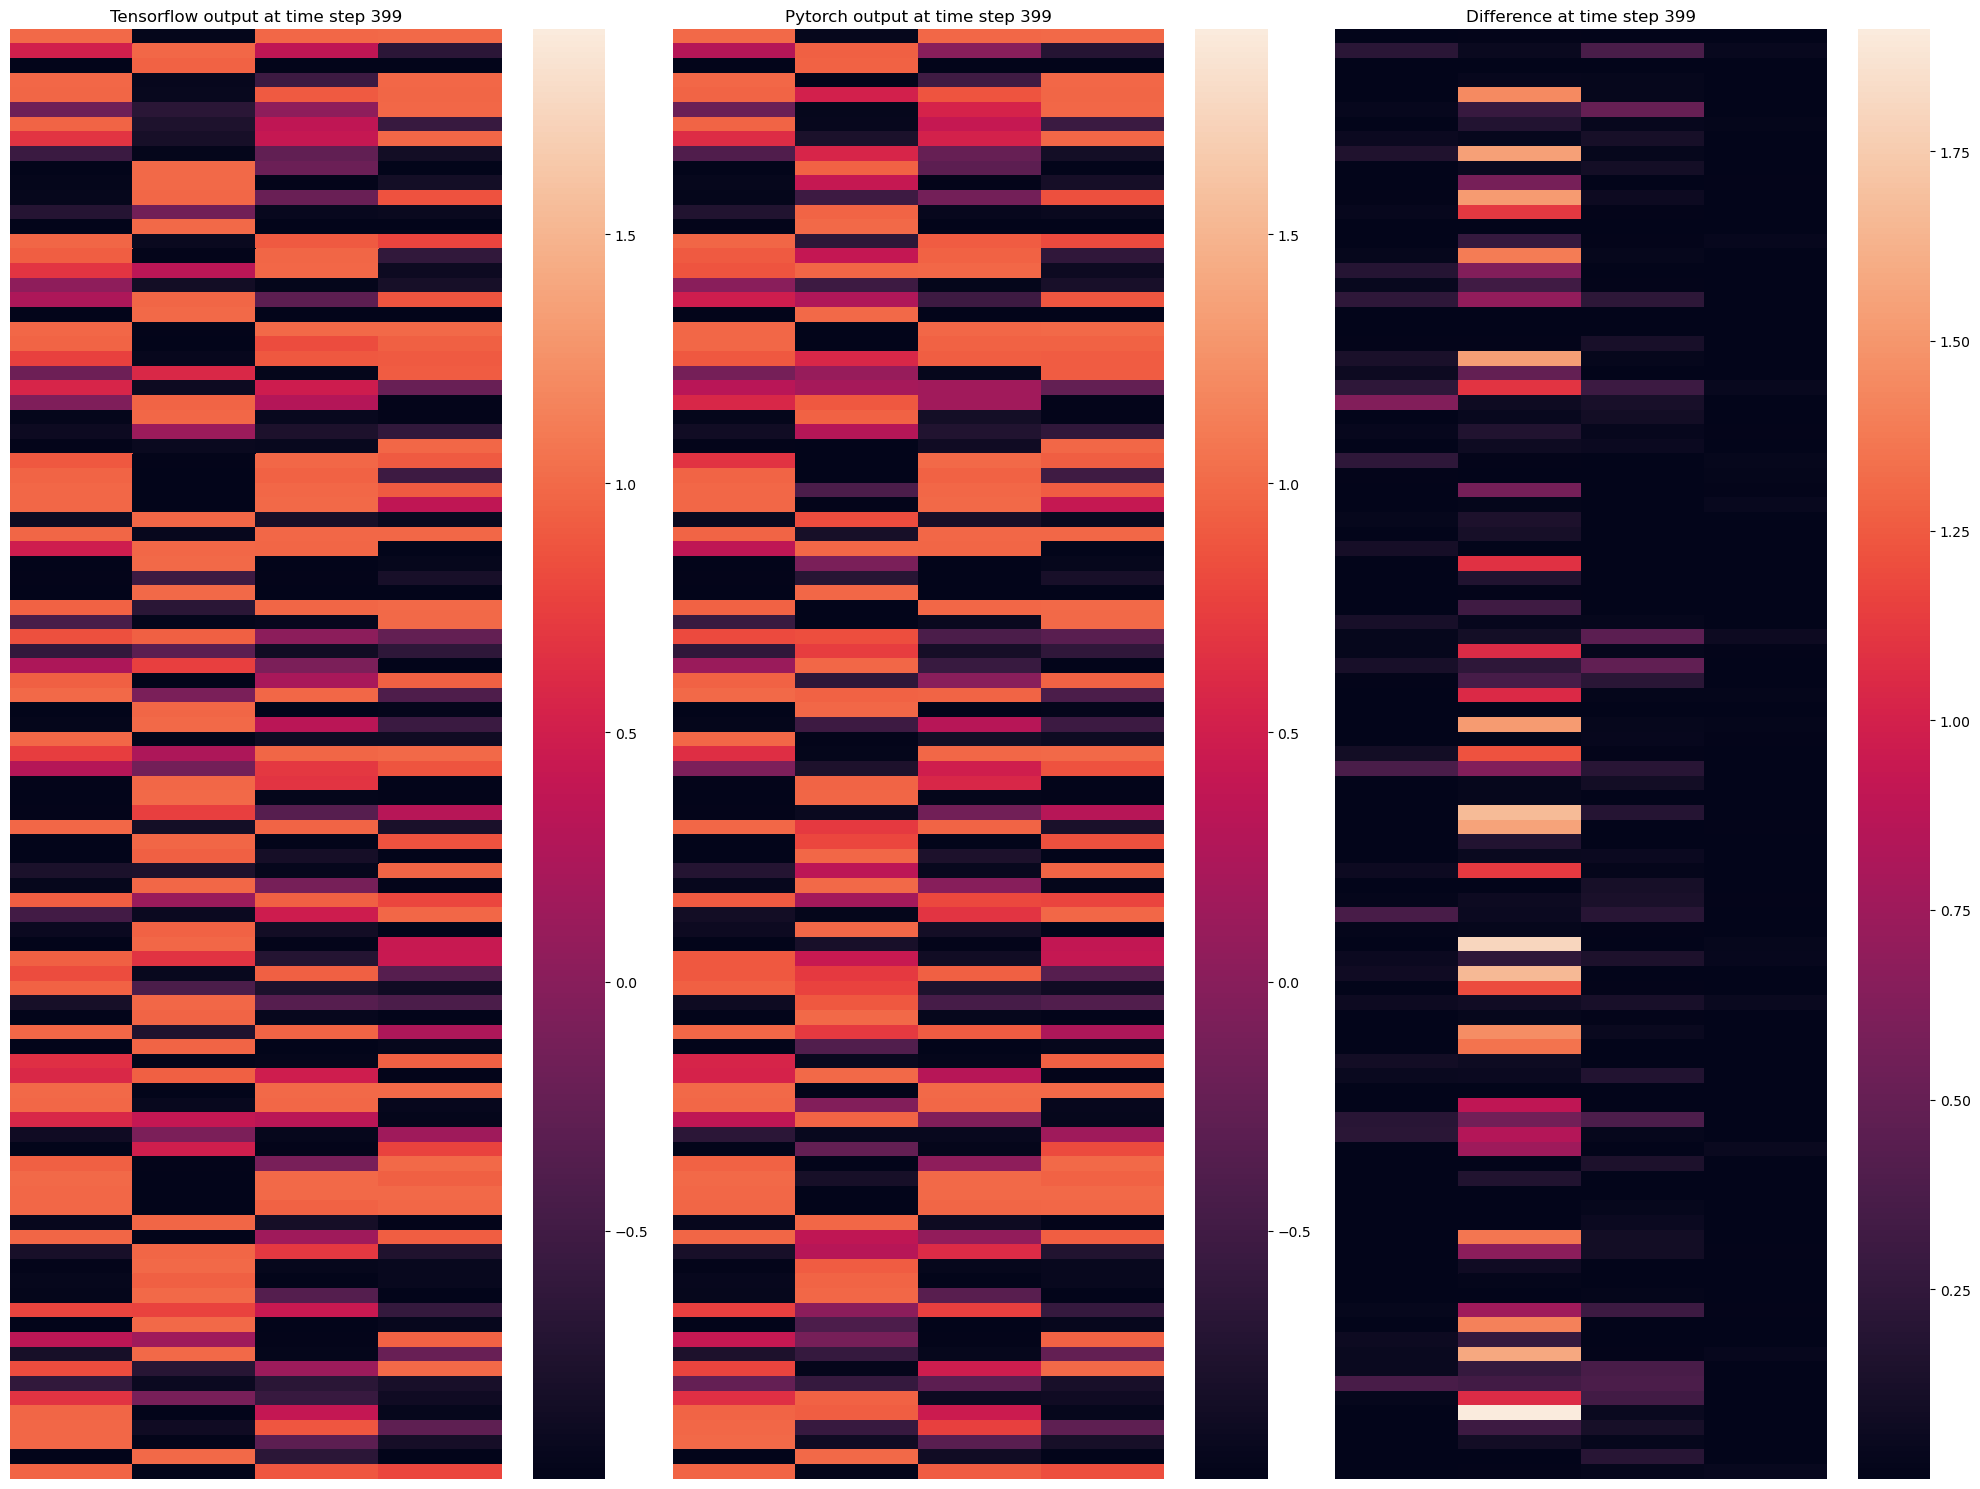

In [71]:
time_step = 399
tf_slice = ys_tf[time_step, ...]
torch_slice = ys_torch[time_step, ...]
diff_slice = np.abs(tf_slice - torch_slice)
max_val = np.amax(np.concatenate([tf_slice, torch_slice, diff_slice]))

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 15), sharey=True)
sns.heatmap(tf_slice, ax=axes[0], vmax=max_val)
axes[0].set_title(f"Tensorflow output at time step {time_step}")
axes[0].set_axis_off()
sns.heatmap(torch_slice, ax=axes[1], vmax=max_val)
axes[1].set_title(f"Pytorch output at time step {time_step}")
axes[1].set_axis_off()
sns.heatmap(diff_slice, ax=axes[2], vmax=max_val)
axes[2].set_title(f"Difference at time step {time_step}")
axes[2].set_axis_off()
plt.tight_layout()
plt.show()

### Test envelope function of the code

In [33]:
W_like = np.random.randn(99, 99)

In [38]:
# Test the envelope
def tensorflow_envelope():
    from cellbox.kernel import get_envelope
    envelope_fn = get_envelope(args)

    params = {}
    W_copy = np.copy(W)
    params["W"] = tf.convert_to_tensor(W_copy, dtype=tf.float32)
    if args.ode_degree == 1:
        def weighted_sum(x):
            return tf.matmul(params['W'], x)
    
    return envelope_fn(weighted_sum(tf.convert_to_tensor(W_like, dtype=tf.float32))).eval(session=tf.compat.v1.Session())
    
def pytorch_envelope():
    from cellbox.kernel_torch import get_envelope
    envelope_fn = get_envelope(args)
    params = {}
    W_copy = np.copy(W)
    params["W"] = torch.tensor(W_copy, dtype=torch.float32)
    if args.ode_degree == 1:
        def weighted_sum(x):
            return torch.matmul(params['W'], x)

    return envelope_fn(weighted_sum(torch.tensor(W_like, dtype=torch.float32))).numpy()


In [39]:
tf_out = tensorflow_envelope()
torch_out = pytorch_envelope()

A small difference indicates that the envelope function produces similar results

In [40]:
np.amax(np.abs(tf_out - torch_out))

2.9802322e-07

### Test dXdT of the code

In [41]:
def tensorflow_dxdt():
    from cellbox.kernel import get_ode_solver, get_envelope, get_dxdt

    params = {}
    W_copy = np.copy(W)
    params["W"] = tf.convert_to_tensor(W_copy, dtype=tf.float32)
    params["alpha"] = tf.convert_to_tensor(np.log(np.exp(alpha) + 1), dtype=tf.float32)
    params["eps"] = tf.convert_to_tensor(np.log(np.exp(eps) + 1), dtype=tf.float32)
    envelope_fn = get_envelope(args)
    ode_solver = get_ode_solver(args)
    _dxdt = get_dxdt(args, params)

    # Determine the input and output shape of the ODE
    mu_t_copy = np.copy(mu_t_np)
    y0 = tf.convert_to_tensor(y0_np, dtype=tf.float32)
    mu_t = tf.convert_to_tensor(mu_t_copy, dtype=tf.float32)
    return _dxdt(y0, mu_t).eval(session=tf.compat.v1.Session())

def pytorch_dxdt():
    from cellbox.kernel_torch import get_ode_solver, get_envelope, get_dxdt

    params = {}
    W_copy = np.copy(W)
    params["W"] = torch.tensor(W_copy, dtype=torch.float32)
    params["alpha"] = torch.tensor(np.log(np.exp(alpha) + 1), dtype=torch.float32)
    params["eps"] = torch.tensor(np.log(np.exp(eps) + 1), dtype=torch.float32)
    envelope_fn = get_envelope(args)
    ode_solver = get_ode_solver(args)
    _dxdt = get_dxdt(args, params)

    # Determine the input and output shape of the ODE
    mu_t_copy = np.copy(mu_t_np)
    y0 = torch.tensor(y0_np, dtype=torch.float32)
    mu_t = torch.tensor(mu_t_copy, dtype=torch.float32)
    return _dxdt(y0, mu_t).numpy()

In [42]:
tf_out = tensorflow_dxdt()
torch_out = pytorch_dxdt()

In [43]:
np.amax(np.abs(tf_out - torch_out))

2.3841858e-07